In [1]:
import triangle
import math
import heapq
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation, PillowWriter, FFMpegWriter
from matplotlib.animation import PillowWriter
import numpy as np
from collections import defaultdict
from shapely.geometry import Point, Polygon, LineString, MultiLineString, MultiPolygon
from shapely.ops import unary_union

In [2]:
TOLERANCE = 0.001

In [3]:
def cast_rays_with_holes(polygon, viewpoint, n_rays=500):
    ray_points = []
    #angles = np.linspace(0, 2 * np.pi, n_rays)
    angles = []
    
    # Extract exterior and holes
    edges = []
    coords = list(polygon.exterior.coords)
    edges.extend(zip(coords[:-1], coords[1:]))
    
    all_vertices = coords

    for interior in polygon.interiors:
        coords = list(interior.coords)
        all_vertices += coords
        edges.extend(zip(coords[:-1], coords[1:]))

    #print(all_vertices)
    
    for vx, vy in all_vertices:
        temp = math.atan2(vy - viewpoint[1], vx - viewpoint[0])
        #print(temp)
        angles.append(temp + 0.000001)
        angles.append(temp)
        angles.append(temp - 0.000001)
    
    angles.sort()

    for angle in angles:
        dx, dy = np.cos(angle), np.sin(angle)
        far_point = (viewpoint[0] + dx * 1000, viewpoint[1] + dy * 1000)
        near_point = (viewpoint[0] + dx * 0.01, viewpoint[1] + dy * 0.01)
        if not polygon.contains(Point(near_point)): # Fix the problem where you are along a boundary
            ray_points.append(viewpoint) 
        else:
            ray = LineString([near_point, far_point])
            min_dist = float('inf')
            closest_pt = None
            for seg_start, seg_end in edges:
                edge = LineString([seg_start, seg_end])
                if ray.intersects(edge):
                    pt = ray.intersection(edge)
                    if isinstance(pt, Point):
                        dist = Point(viewpoint).distance(pt)
                        if dist < min_dist:
                            min_dist = dist
                            closest_pt = pt
            if closest_pt:
                #ray_points.append((closest_pt.x, closest_pt.y))
                ray_points.append((round(closest_pt.x, 3), round(closest_pt.y, 3)))
            
    return ray_points


In [4]:
def is_window(polygon, point1, point2):
    """ Points 1 and 2 are an edge on the visibilty polygon and we would like to 
    know if they are a window, or if they are on the edge of a boundry or hole """
    
    if math.hypot(point1[0]-point2[0], point1[1]-point2[1]) < 0.0001:
        return False # Too short a segment to be a real window

    
    boundary_coords = list(polygon.exterior.coords)
    edges = [LineString([boundary_coords[i], boundary_coords[i+1]]) for i in range(len(boundary_coords) - 1)]
    
    
    for interior in list(polygon.interiors):
        pts = list(interior.coords)
        edges += [LineString([pts[i], pts[i+1]]) for i in range(len(pts) - 1)]
    
    line1 = LineString([point1, point2])
    for boundary_line in edges:
        if boundary_line.intersects(line1) and boundary_line.intersection(line1).geom_type == 'LineString':
            return False
    
    return True


In [5]:
def get_windows(polygon, vis_polygon):
    """Find the newly created edges as they represent the visibility windows."""
    vis_coords= list(vis_polygon.exterior.coords)

    # Create a list of LineStrings for each segment
    vis_segments = [LineString(vis_coords[i:i+2]) for i in range(len(vis_coords) - 1)]
    poly_coords = list(polygon.exterior.coords)
    poly_segments = [LineString(poly_coords[i:i+2]) for i in range(len(poly_coords) - 1)]
    for interior in list(polygon.interiors):
        pts = list(interior.coords)
        poly_segments += [LineString([pts[i], pts[i+1]]) for i in range(len(pts) - 1)]
    
    multi_line_vis = unary_union(vis_segments)
    new_vision_poly = unary_union(poly_segments)
    
    buffered_polygon = new_vision_poly.buffer(TOLERANCE) #Grow a bit to remove more from the polygon
    
    result = multi_line_vis.difference(buffered_polygon)

    return result
    

In [6]:
def dijkstra(graph, start_node):
    """
    Finds the shortest paths and distances from a start_node to all other nodes in a graph.

    Args:
        graph (dict): A dictionary representing the graph where keys are nodes
                      and values are dictionaries of neighbors and their edge weights.
                      Example: {'A': {'B': 1, 'C': 4}, 'B': {'A': 1, 'C': 2, 'D': 5}}
        start_node: The starting node for finding shortest paths.

    Returns:
        tuple:
            distances (dict): Shortest distances from start_node to each node.
            paths (dict): Shortest paths from start_node to each node as lists.
    """
    distances = {node: float('inf') for node in graph}
    previous_nodes = {node: None for node in graph}
    distances[start_node] = 0
    priority_queue = [(0, start_node)]

    while priority_queue:
        current_distance, current_node = heapq.heappop(priority_queue)

        if current_distance > distances[current_node]:
            continue

        for neighbor, weight in graph[current_node].items():
            distance = current_distance + weight
            if distance < distances[neighbor]:
                distances[neighbor] = distance
                previous_nodes[neighbor] = current_node
                heapq.heappush(priority_queue, (distance, neighbor))

    # Reconstruct paths
    paths = {}
    for node in graph:
        path = []
        current = node
        while current is not None:
            path.insert(0, current)
            current = previous_nodes[current]
        if path[0] == start_node:
            paths[node] = path
        else:
            paths[node] = []  # Unreachable

    return distances, paths

In [7]:
def is_visible(polygon, point1, point2):
    """
    Checks if the line segment between two points lies entirely within or on the edge of the polygon.

    Args:
        polygon (Polygon): A Shapely Polygon (can be concave).
        point1, point2: Tuples representing the coordinates of the two vertices.

    Returns:
        bool: True if the line segment is fully inside or on the boundary of the polygon.
    """
    segment = LineString([point1, point2])
    return polygon.buffer(0.05).covers(segment)

## Set up the current problem and load the boundary and hole information

In [8]:
# Define outer polygon and hole
#outer = [(0,0), (10,0), (10,10), (0,10)]
#holes = [[(4,2), (6,4), (4,6), (2,4)], [(2,6), (3,6), (3,7), (2,7)]]

outer = [[0.29155672823219003, 4.823218997361478],
 [3.0356200527704487, 2.5013192612137205],
 [4.671503957783641, 4.559366754617415],
 [8.127968337730872, 2.9762532981530345],
 [9.5, 7.356200527704486],
 [6.967018469656993, 8.04221635883905],
 [6.281002638522428, 7.118733509234828],
 [8.339050131926122, 6.643799472295514],
 [6.729551451187335, 4.823218997361478],
 [3.088390501319261, 7.118733509234828],
 [4.882585751978892, 8.04221635883905],
 [2.112137203166227, 8.04221635883905],
 [1.9010554089709761, 6.643799472295514],
 [3.9591029023746707, 5.271767810026385],
 [2.824538258575198, 4.137203166226913],
 [1.6899736147757256, 4.823218997361478],
 [2.587071240105541, 5.509234828496043]]
holes = []

"""
outer = [[0.4035874439461883, 0.3139013452914798],
 [4.992526158445441, 0.25411061285500747],
 [5.9790732436472345, 1.210762331838565],
 [6.9207772795216735, 0.25411061285500747],
 [9.985052316890881, 0.25411061285500747],
 [8.04185351270553, 2.301943198804185],
 [10.0, 4.28998505231689],
 [6.9207772795216735, 4.304932735426009],
 [5.93423019431988, 3.363228699551569],
 [4.992526158445441, 4.304932735426009],
 [4.394618834080717, 4.304932735426009]]

holes = [[[6.606875934230194, 1.71898355754858],
  [7.817638266068759, 1.7339312406576979],
  [7.832585949177877, 1.7040358744394617],
  [7.4140508221225705, 1.3303437967115097],
  [6.9805680119581455, 1.3452914798206277]],
 [[5.85949177877429, 2.301943198804185],
  [4.409566517189835, 0.8221225710014947],
  [3.0642750373692076, 0.8221225710014947],
  [4.484304932735426, 2.227204783258595],
  [4.499252615844544, 2.316890881913303],
  [4.0807174887892375, 2.7503736920777277],
  [5.396113602391629, 2.7503736920777277]],
 [[6.606875934230194, 3.2137518684603883],
  [8.325859491778774, 3.2137518684603883],
  [7.473841554559042, 2.3617339312406576]]]
"""

polygon = Polygon(outer, holes)
viewpoint = (2,4.15) #(1,3.5)
#viewpoint = (6.3, 2.4)
#destination = [7, 7.5]
all_windows = [] # All of the windows we use
all_regions = {} # All of the regions we find by distance

### Compute the initial visibility from the starting point

In [9]:
# Compute visibility
vis_points = cast_rays_with_holes(polygon, viewpoint)
vis_polygon = Polygon(vis_points)
#Simplify the polygon to remove redundancy
vis_polygon = vis_polygon.simplify(tolerance=0.1, preserve_topology=True)

all_regions[0] = [vis_polygon] # add the initial region as the first entry
region_groups = {}

In [10]:
#Find all the windows for the next step
windows_segments = get_windows(polygon, vis_polygon)
current_windows = []
for window in windows_segments.geoms:
    # Add the start point of the current LineString
    current_windows.append([window.coords[0], window.coords[-1]])

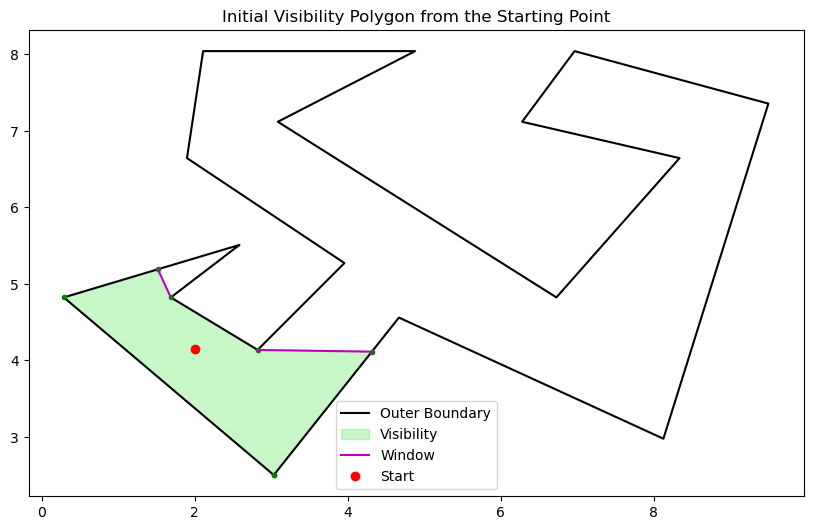

In [11]:
# Plotting
fig, ax = plt.subplots(figsize=(10, 10))
ox, oy = zip(*polygon.exterior.coords)
ax.plot(ox, oy, 'k-', label='Outer Boundary')

for interior in polygon.interiors:
    hx, hy = zip(*interior.coords)
    ax.plot(hx, hy, 'k-', label='Hole')
    ax.plot(hx, hy, 'b.', label='Vertices')    

vx, vy = zip(*vis_polygon.exterior.coords)
ax.plot(vx,vy, 'g.')
ax.fill(vx, vy, color='lightgreen', alpha=0.5, label='Visibility')

for i,item in enumerate(current_windows):
    px,py = zip(*item)
    if i == 0:
        ax.plot(px, py, "m-", label='Window')
    else:
        ax.plot(px, py, "m-")

ax.plot(*viewpoint, 'ro', label='Start')
#ax.set_xlim(0, 10)
#ax.set_ylim(0, 10)
ax.set_aspect('equal')
plt.title("Initial Visibility Polygon from the Starting Point")
plt.legend()
plt.show()

### Construct the unvisited (not-visible) regions that remain

In [12]:
# construct the clean unvisited polygon region(s)
unvisited_polygon = polygon - vis_polygon.buffer(TOLERANCE)
# To Do: correct the unvisited region to removie the small overcut

# If there is only one, make it into a multipolygon for ease
if unvisited_polygon.geom_type == 'Polygon': 
    unvisited_polygon = MultiPolygon([unvisited_polygon])


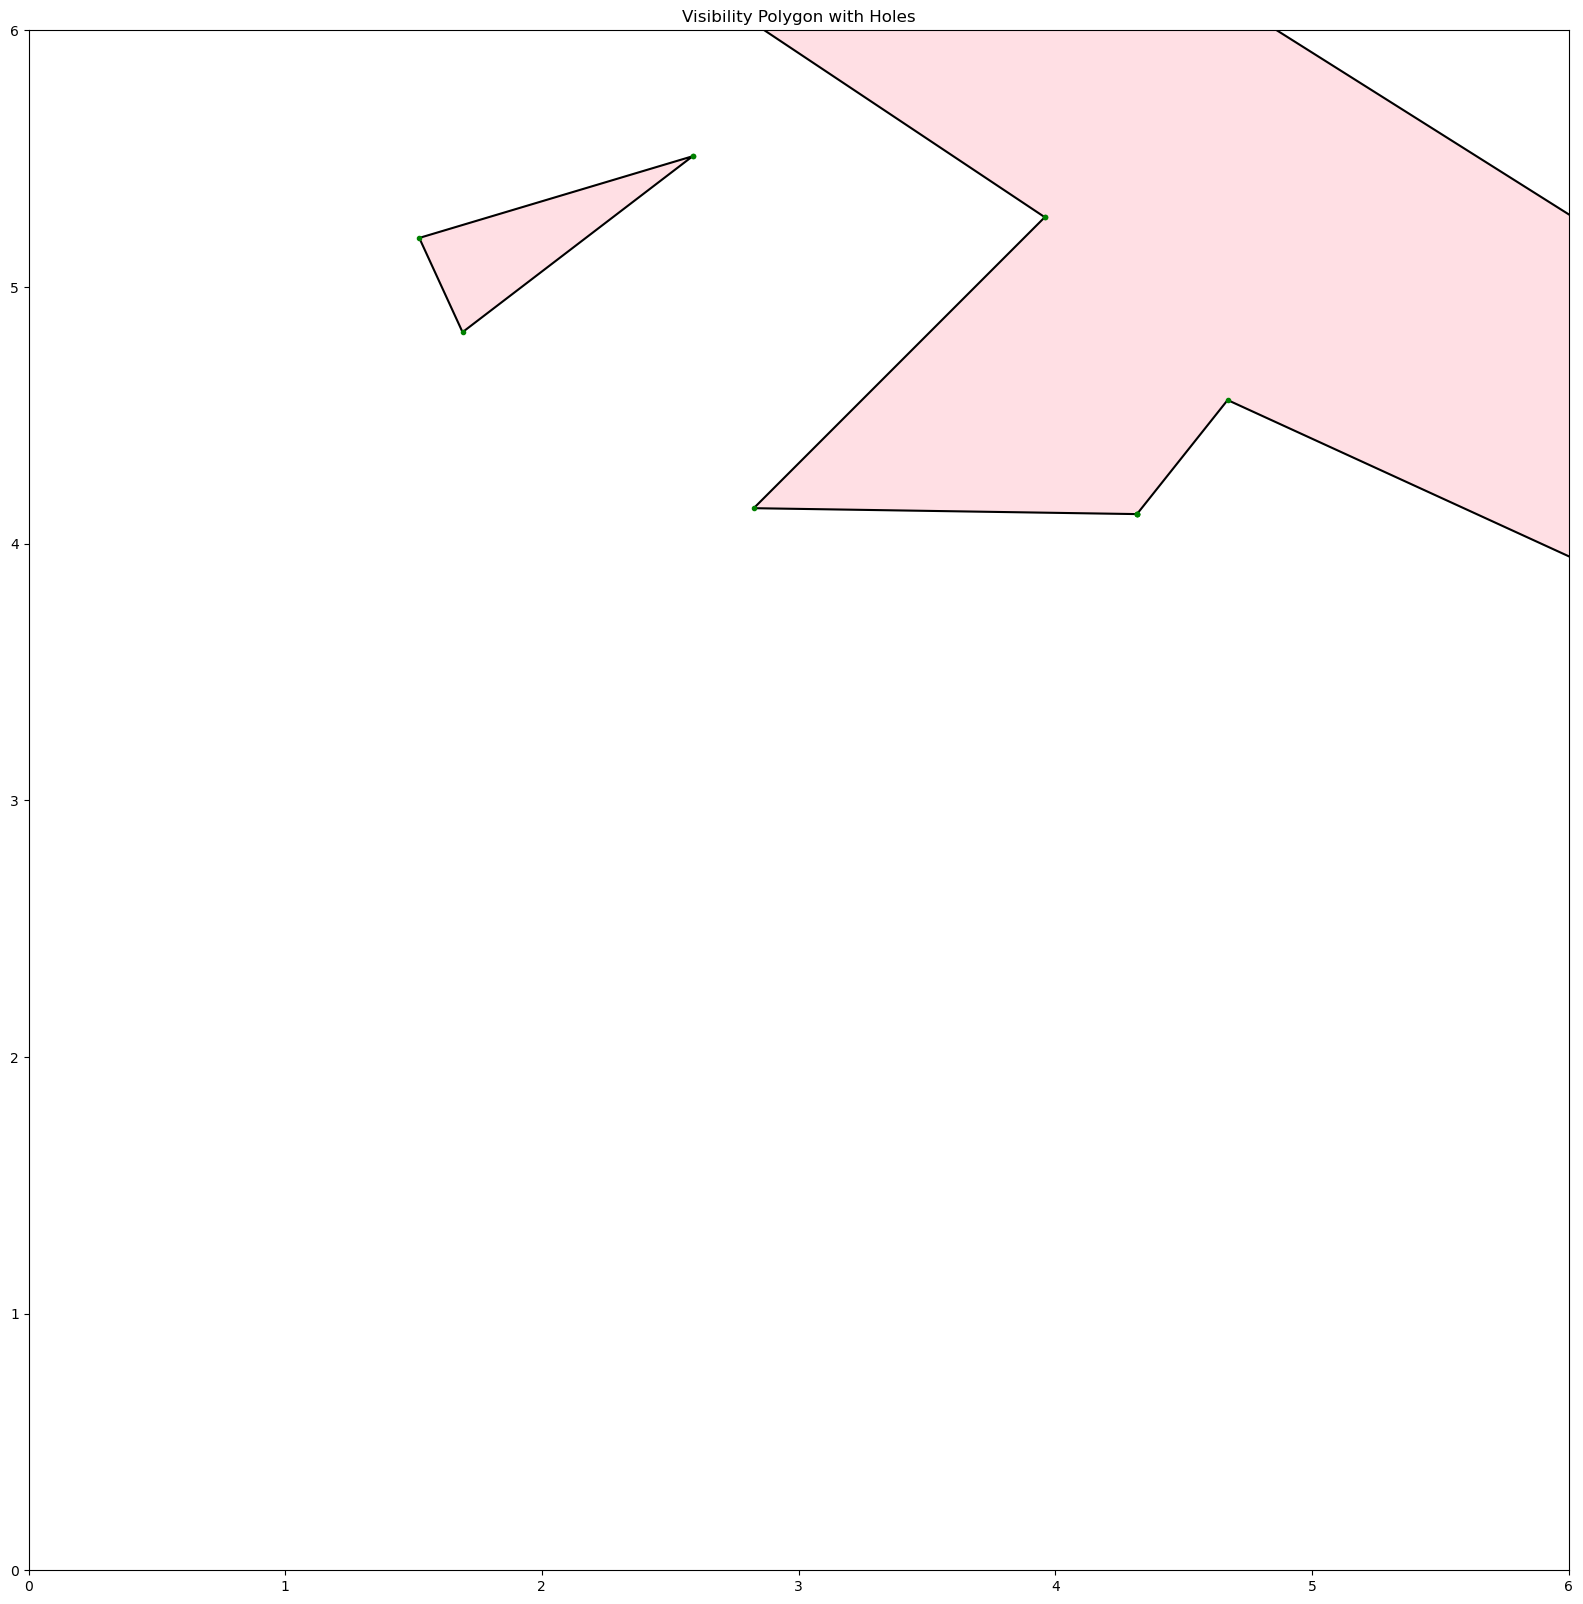

In [13]:
# Plotting
fig, ax = plt.subplots(figsize=(20, 20))

for poly in unvisited_polygon.geoms:
    ox, oy = zip(*poly.exterior.coords)
    ax.plot(ox, oy, 'k-', label='Outer Boundary')

    for interior in poly.interiors:
        hx, hy = zip(*interior.coords)
        ax.plot(hx, hy, 'k-', label='Hole')
        ax.plot(hx, hy, 'b.', label='Vertices')    

    vx, vy = zip(*poly.exterior.coords)
    ax.plot(vx,vy, 'g.')
    ax.fill(vx, vy, color='pink', alpha=0.5, label='Visibility')

ax.set_xlim(0, 6)
ax.set_ylim(0, 6)
ax.set_aspect('equal')
plt.title("Visibility Polygon with Holes")
#plt.legend()
plt.show()

In [14]:
def find_group(segment, polygons):
    group = -1
    start = segment[0]
    finish = segment[1]
    begin = [0,0]
    end = [0,0]
    ds = float('inf')
    de = float('inf')
    for index, poly in enumerate(polygons.geoms):
        for point in poly.exterior.coords:
            dx = point[0] - start[0]
            dy = point[1] - start[1]
            dist = dx**2 + dy**2
            if dist < ds:
                ds = dist
                group = index
                begin = point
            dx = point[0] - finish[0]
            dy = point[1] - finish[1]
            dist = dx**2 + dy**2
            if dist < de:
                de = dist
                group = index
                end = point
    return group, [begin, end]

### Marshal the unvisited polygons and windows together for processing

In [15]:
work_groups = [[poly,[]] for poly in unvisited_polygon.geoms]

for segment in current_windows: # Extract out the windows and group them in with the polygons
    group, corrected = find_group(segment, unvisited_polygon)
    work_groups[group][1].append(corrected) # Add the corrected segment to the correct group

work_groups

[[<POLYGON ((3.959 5.272, 1.901 6.644, 2.112 8.042, 4.883 8.042, 3.088 7.119, ...>,
  [[(4.318015403396714, 4.114999881360647),
    (2.825330125346675, 4.13799503299839)]]],
 [<POLYGON ((2.587 5.509, 1.691 4.824, 1.522 5.191, 2.587 5.509))>,
  [[(1.690733114005132, 4.823799790889847),
    (1.522113459189458, 5.190971583624569)]]]]

### Project from the windows to the next set of visible regions

In [16]:
result_polys = []
for current_poly, current_windows in work_groups: # extract out the current polygon for processing
    new_vis_poly = Polygon()
    for vis_segment in current_windows:
        for vis_point in vis_segment:
            new_vis_points = cast_rays_with_holes(current_poly, vis_point)
            temp_poly = Polygon(new_vis_points)
            new_vis_poly = new_vis_poly.union(temp_poly)

    #Simplify the polygon to remove redundancy
    new_vis_poly = new_vis_poly.simplify(tolerance=0.1, preserve_topology=True)
    
    result_polys.append(new_vis_poly)
    all_windows += current_windows # add in all the working windows


In [17]:
all_regions[1] = result_polys # add in the polygons for the current step
region_groups[0] = work_groups

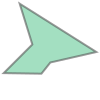

In [18]:
result_polys[0]

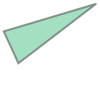

In [19]:
result_polys[1]

### Construct the next unvisited (not-visible) regions that remain

In [20]:
# construct the clean unvisited polygon region(s)
for poly in result_polys:
    unvisited_polygon = unvisited_polygon - poly.buffer(TOLERANCE)
    unvisited_polygon = unvisited_polygon.simplify(tolerance=0.1, preserve_topology=True)

# If there is only one, make it into a multipolygon for ease
if unvisited_polygon.geom_type == 'Polygon': 
    unvisited_polygon = MultiPolygon([unvisited_polygon])


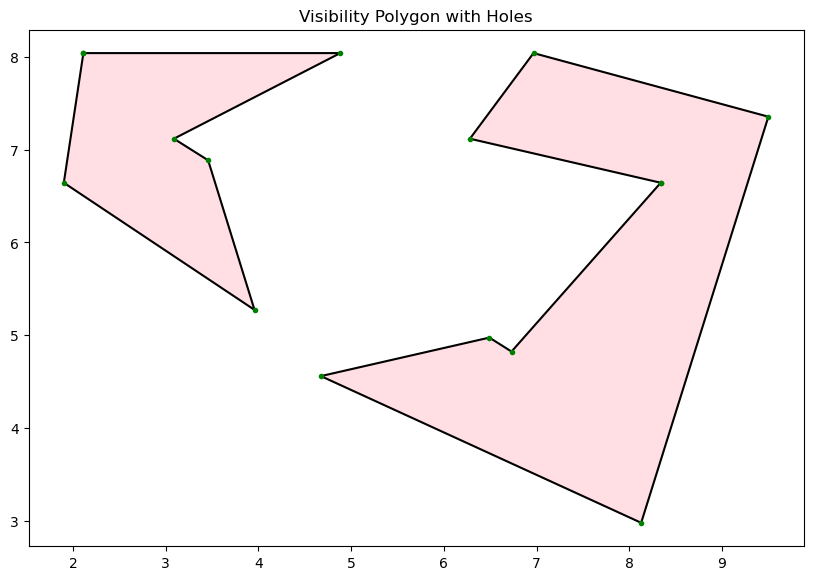

In [21]:
# Plotting
fig, ax = plt.subplots(figsize=(10, 10))

for poly in unvisited_polygon.geoms:
    ox, oy = zip(*poly.exterior.coords)
    ax.plot(ox, oy, 'k-', label='Outer Boundary')

    for interior in poly.interiors:
        hx, hy = zip(*interior.coords)
        ax.plot(hx, hy, 'k-', label='Hole')
        ax.plot(hx, hy, 'b.', label='Vertices')    

    vx, vy = zip(*poly.exterior.coords)
    ax.plot(vx,vy, 'g.')
    ax.fill(vx, vy, color='pink', alpha=0.5, label='Visibility')

#ax.set_xlim(0, 10)
#ax.set_ylim(0, 10)
ax.set_aspect('equal')
plt.title("Visibility Polygon with Holes")
#plt.legend()
plt.show()

### Marshal the unvisited polygons and windows together for processing

In [22]:
work_groups = [[poly,[]] for poly in unvisited_polygon.geoms]

#Find all the windows for the next step
for group, poly in enumerate(unvisited_polygon.geoms):
    windows_segments = get_windows(polygon, poly)
    if windows_segments.geom_type == 'LineString':
        windows_segments = MultiLineString([windows_segments])
    current_windows = []
    for window in windows_segments.geoms:
        # Add the start point of the current LineString
        current_windows.append([window.coords[0], window.coords[-1]])
        for segment in current_windows: # Extract out the windows and group them in with the polygons
                group, corrected = find_group(segment, unvisited_polygon)
                work_groups[group][1].append(corrected) # Add the corrected segment to the correct group

work_groups

[[<POLYGON ((2.112 8.042, 4.883 8.042, 3.088 7.119, 3.458 6.886, 3.958 5.273, ...>,
  [[(3.4576539423447197, 6.885936992066605),
    (3.957743505299514, 5.272674074743156)]]],
 [<POLYGON ((8.339 6.644, 6.281 7.119, 6.967 8.042, 9.5 7.356, 8.128 2.976, 4....>,
  [[(4.673697950341661, 4.558361872529772),
    (6.490936449663581, 4.973650193974279)]]]]

### Project from the windows to the next set of visible regions

In [23]:
result_polys = []
for current_poly, current_windows in work_groups: # extract out the current polygon for processing
    new_vis_poly = Polygon()
    for vis_segment in current_windows:
        for vis_point in vis_segment:
            new_vis_points = cast_rays_with_holes(current_poly, vis_point)
            temp_poly = Polygon(new_vis_points)
            new_vis_poly = new_vis_poly.union(temp_poly)

    #Simplify the polygon to remove redundancy
    new_vis_poly = new_vis_poly.simplify(tolerance=0.1, preserve_topology=True)
    
    result_polys.append(new_vis_poly)
    all_windows += current_windows # add in all the working windows


In [24]:
all_regions[2] = result_polys # add in the polygons for the current step
region_groups[1] = work_groups

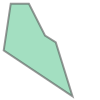

In [25]:
result_polys[0]

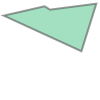

In [26]:
result_polys[1]

### Construct the next unvisited (not-visible) regions that remain

In [27]:
# construct the clean unvisited polygon region(s)
for poly in result_polys:
    unvisited_polygon = unvisited_polygon - poly.buffer(TOLERANCE)
    unvisited_polygon = unvisited_polygon.simplify(tolerance=0.1, preserve_topology=True)

# If there is only one, make it into a multipolygon for ease
if unvisited_polygon.geom_type == 'Polygon': 
    unvisited_polygon = MultiPolygon([unvisited_polygon])


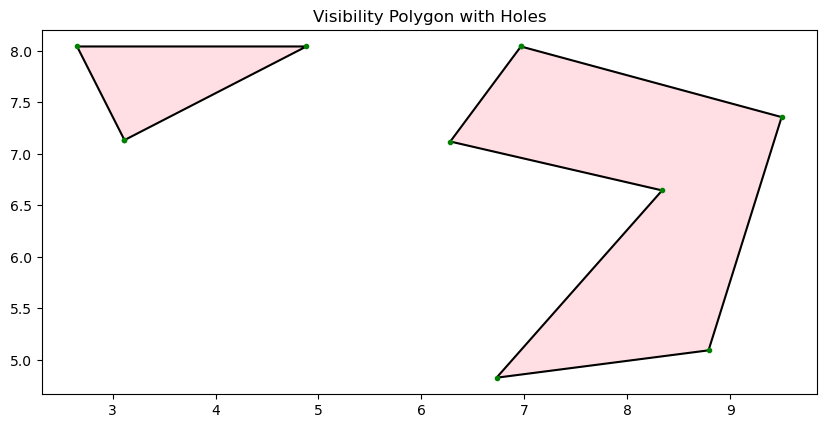

In [28]:
# Plotting
fig, ax = plt.subplots(figsize=(10, 10))

for poly in unvisited_polygon.geoms:
    ox, oy = zip(*poly.exterior.coords)
    ax.plot(ox, oy, 'k-', label='Outer Boundary')

    for interior in poly.interiors:
        hx, hy = zip(*interior.coords)
        ax.plot(hx, hy, 'k-', label='Hole')
        ax.plot(hx, hy, 'b.', label='Vertices')    

    vx, vy = zip(*poly.exterior.coords)
    ax.plot(vx,vy, 'g.')
    ax.fill(vx, vy, color='pink', alpha=0.5, label='Visibility')

#ax.set_xlim(0, 10)
#ax.set_ylim(0, 10)
ax.set_aspect('equal')
plt.title("Visibility Polygon with Holes")
#plt.legend()
plt.show()

### Marshal the unvisited polygons and windows together for processing

In [29]:
work_groups = [[poly,[]] for poly in unvisited_polygon.geoms]

#Find all the windows for the next step
for group, poly in enumerate(unvisited_polygon.geoms):
    windows_segments = get_windows(polygon, poly)
    if windows_segments.geom_type == 'LineString':
        windows_segments = MultiLineString([windows_segments])
    current_windows = []
    for window in windows_segments.geoms:
        # Add the start point of the current LineString
        current_windows.append([window.coords[0], window.coords[-1]])
        for segment in current_windows: # Extract out the windows and group them in with the polygons
                group, corrected = find_group(segment, unvisited_polygon)
                work_groups[group][1].append(corrected) # Add the corrected segment to the correct group

work_groups

[[<POLYGON ((3.116 7.133, 2.655 8.042, 4.883 8.042, 3.116 7.133))>,
  [[(3.1155950568108874, 7.132735853973165),
    (2.65501135255233, 8.04221635883905)]]],
 [<POLYGON ((6.967 8.042, 9.5 7.356, 8.79 5.09, 6.73 4.824, 8.339 6.644, 6.281...>,
  [[(8.7901038211602, 5.089993495254355),
    (6.73028136135387, 4.824044633451493)]]]]

### Project from the windows to the next set of visible regions

In [30]:
result_polys = []
for current_poly, current_windows in work_groups: # extract out the current polygon for processing
    new_vis_poly = Polygon()
    for vis_segment in current_windows:
        for vis_point in vis_segment:
            new_vis_points = cast_rays_with_holes(current_poly, vis_point)
            temp_poly = Polygon(new_vis_points)
            new_vis_poly = new_vis_poly.union(temp_poly)

    #Simplify the polygon to remove redundancy
    new_vis_poly = new_vis_poly.simplify(tolerance=0.1, preserve_topology=True)
    
    result_polys.append(new_vis_poly)
    all_windows += current_windows # add in all the working windows


In [31]:
all_regions[3] = result_polys # add in the polygons for the current step
region_groups[2] = work_groups

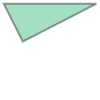

In [32]:
result_polys[0]

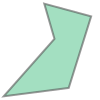

In [33]:
result_polys[1]

### Construct the next unvisited (not-visible) regions that remain

In [34]:
# construct the clean unvisited polygon region(s)
for poly in result_polys:
    unvisited_polygon = unvisited_polygon - poly.buffer(TOLERANCE)
    unvisited_polygon = unvisited_polygon.simplify(tolerance=0.1, preserve_topology=True)

# If there is only one, make it into a multipolygon for ease
if unvisited_polygon.geom_type == 'Polygon': 
    unvisited_polygon = MultiPolygon([unvisited_polygon])


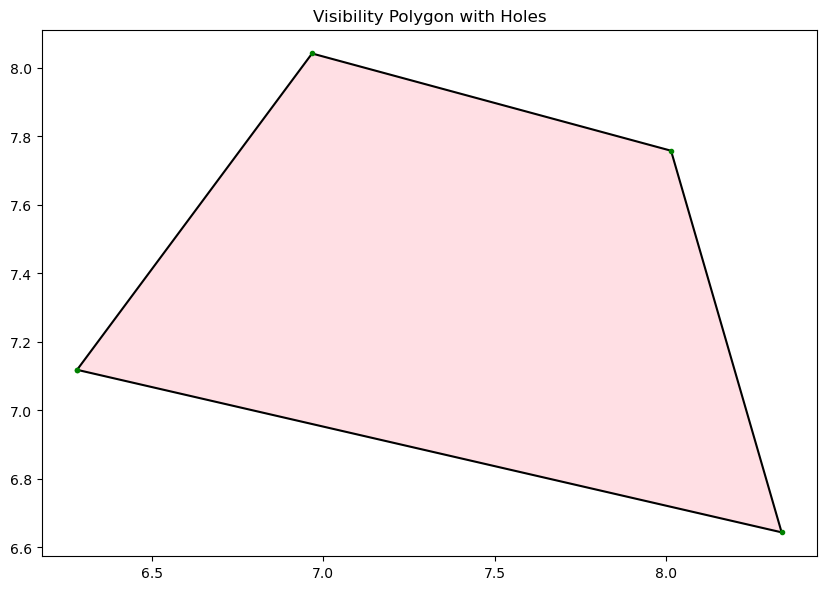

In [35]:
# Plotting
fig, ax = plt.subplots(figsize=(10, 10))

for poly in unvisited_polygon.geoms:
    ox, oy = zip(*poly.exterior.coords)
    ax.plot(ox, oy, 'k-', label='Outer Boundary')

    for interior in poly.interiors:
        hx, hy = zip(*interior.coords)
        ax.plot(hx, hy, 'k-', label='Hole')
        ax.plot(hx, hy, 'b.', label='Vertices')    

    vx, vy = zip(*poly.exterior.coords)
    ax.plot(vx,vy, 'g.')
    ax.fill(vx, vy, color='pink', alpha=0.5, label='Visibility')

#ax.set_xlim(0, 10)
#ax.set_ylim(0, 10)
ax.set_aspect('equal')
plt.title("Visibility Polygon with Holes")
#plt.legend()
plt.show()

### Marshal the unvisited polygons and windows together for processing

In [36]:
work_groups = [[poly,[]] for poly in unvisited_polygon.geoms]

#Find all the windows for the next step
for group, poly in enumerate(unvisited_polygon.geoms):
    windows_segments = get_windows(polygon, poly)
    if windows_segments.geom_type == 'LineString':
        windows_segments = MultiLineString([windows_segments])
    current_windows = []
    for window in windows_segments.geoms:
        # Add the start point of the current LineString
        current_windows.append([window.coords[0], window.coords[-1]])
        for segment in current_windows: # Extract out the windows and group them in with the polygons
                group, corrected = find_group(segment, unvisited_polygon)
                work_groups[group][1].append(corrected) # Add the corrected segment to the correct group

work_groups

[[<POLYGON ((6.281 7.119, 6.967 8.042, 8.015 7.758, 8.338 6.644, 6.281 7.119))>,
  [[(8.015071087653777, 7.758368774798255),
    (8.337886310842736, 6.644250056537875)]]]]

### Project from the windows to the next set of visible regions

In [37]:
result_polys = []
for current_poly, current_windows in work_groups: # extract out the current polygon for processing
    new_vis_poly = Polygon()
    for vis_segment in current_windows:
        for vis_point in vis_segment:
            new_vis_points = cast_rays_with_holes(current_poly, vis_point)
            temp_poly = Polygon(new_vis_points)
            new_vis_poly = new_vis_poly.union(temp_poly)

    #Simplify the polygon to remove redundancy
    new_vis_poly = new_vis_poly.simplify(tolerance=0.1, preserve_topology=True)
    
    result_polys.append(new_vis_poly)
    all_windows += current_windows # add in all the working windows


In [38]:
all_regions[4] = result_polys # add in the polygons for the current step
region_groups[3] = work_groups

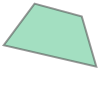

In [39]:
result_polys[0]

## Solve the shortest path problem

In [40]:
# Gather all the polygon regions and flatten them for individual indices
poly_set = [] # Empty polygon for the start

for i in all_regions.values():
    for j in i:
        poly_set.append(j)
poly_set

[<POLYGON ((3.036 2.501, 4.318 4.114, 2.825 4.137, 1.69 4.823, 1.521 5.191, 0...>,
 <POLYGON ((2.825 4.138, 3.959 5.272, 3.458 6.885, 6.49 4.974, 4.672 4.559, 4...>,
 <POLYGON ((2.587 5.509, 1.691 4.824, 1.691 4.824, 1.522 5.191, 2.587 5.509))>,
 <POLYGON ((3.137 7.088, 3.458 6.886, 3.958 5.273, 1.901 6.644, 2.112 8.042, ...>,
 <POLYGON ((6.73 4.823, 8.79 5.089, 8.128 2.976, 4.674 4.558, 6.491 4.974, 6....>,
 <POLYGON ((3.116 7.133, 2.655 8.042, 4.883 8.042, 3.116 7.133))>,
 <POLYGON ((8.339 6.644, 8.016 7.758, 9.5 7.356, 8.79 5.09, 6.73 4.824, 8.339...>,
 <POLYGON ((8.015 7.758, 8.338 6.644, 6.281 7.119, 6.967 8.042, 8.015 7.758))>]

In [41]:
# Gather all the polygons and vertices

vert_set = [viewpoint]
vert_group = [0]
poly_dict = {i:[] for i in region_groups.keys()}

for key,item in region_groups.items():
    for block in item:
        poly_dict[key].append(len(poly_set))
        #poly_set.append((block[0], key+1))
        for points in block[1]:
            for point in points:
                vert_set.append(point)
                vert_group.append(key+1) 

for point in vert_set:
    print(point)

(2, 4.15)
(4.318015403396714, 4.114999881360647)
(2.825330125346675, 4.13799503299839)
(1.690733114005132, 4.823799790889847)
(1.522113459189458, 5.190971583624569)
(3.4576539423447197, 6.885936992066605)
(3.957743505299514, 5.272674074743156)
(4.673697950341661, 4.558361872529772)
(6.490936449663581, 4.973650193974279)
(3.1155950568108874, 7.132735853973165)
(2.65501135255233, 8.04221635883905)
(8.7901038211602, 5.089993495254355)
(6.73028136135387, 4.824044633451493)
(8.015071087653777, 7.758368774798255)
(8.337886310842736, 6.644250056537875)


In [42]:
# Identify the in-window vertices for each polygon
verts_in_poly = [[] for i in range(len(poly_set))]
for vert_index, point in enumerate(vert_set):
    for poly_num, temp in enumerate(poly_set):
        if temp.contains(Point(point)) or temp.touches(Point(point)):
            verts_in_poly[poly_num].append(vert_index)
            break
verts_in_poly

[[0], [1, 2], [3, 4], [5, 6], [7, 8], [9, 10], [11, 12], [13, 14]]

In [43]:
# Find the out vertices for each polygon
verts_out_poly = [[] for i in range(len(poly_set))]
verts_out = [() for i in range(len(vert_set))] # Make room for the new points to reserve space
verts_out[0] = None
working_pts = [(x,0) for x in list(poly_set[0].exterior.coords)]

for i in range(1, len(poly_set)):
    for idx in verts_in_poly[i]: # find the closest point in poly0 to the in-verts of ploy1
        closest_pt = working_pts[0][0] # The actual point
        closest_poly = working_pts[0][1]
        this_in_pt = vert_set[idx]
        #print("For", this_in_pt,idx)
        for working_pt, poly_num in working_pts:
            d_close = math.sqrt((this_in_pt[0] - closest_pt[0])**2 + (this_in_pt[1] - closest_pt[1])**2)
            d_this = math.sqrt((this_in_pt[0] - working_pt[0])**2 + (this_in_pt[1] - working_pt[1])**2)
            if(d_this < d_close):
                closest_pt = working_pt
                closest_poly = poly_num
                #print("Closest", working_pt, closest_poly)
        verts_out[idx] = closest_pt
        verts_out_poly[closest_poly].append(idx)
        #print(closest_pt, poly_num, idx)
    working_pts += [(x,i) for x in list(poly_set[i].exterior.coords)]
    
verts_out_poly


[[1, 2, 3, 4], [5, 6, 7, 8], [], [9, 10], [11, 12], [], [13, 14], []]

In [44]:
# construct the graph connections for vertices
#weights = {'A': {'B': 1, 'C': 4}, 'B': {'A': 1, 'C': 2, 'D': 5}}
graph = {}
for poly_idx in range(len(poly_set)):
    in_idx = verts_in_poly[poly_idx]
    out_idx = verts_out_poly[poly_idx]
    for i in in_idx:
        i_point = vert_set[i]
        graph[i] = {}
        for j in out_idx:
            j_point = vert_set[j]
            if is_visible(poly_set[poly_idx], i_point, j_point):
                distance = math.sqrt((i_point[0] - j_point[0])**2 + (i_point[1] - j_point[1])**2)
                graph[i][j] = distance
    
graph

{0: {1: 2.31827962478412,
  2: 0.8254174307812187,
  3: 0.7413853012949231,
  4: 1.1454245430414474},
 1: {5: 2.901433148489037, 6: 1.2124377833861837, 7: 0.5684012046210806},
 2: {6: 1.6030772254857324, 7: 1.8955663787518227, 8: 3.759652812818989},
 3: {},
 4: {},
 5: {9: 0.42179848199231446},
 6: {9: 2.041823653463763, 10: 3.0606331902396304},
 7: {11: 4.15059387022991, 12: 2.0736737100859433},
 8: {12: 0.2822548679675333},
 9: {},
 10: {},
 11: {13: 2.7786511782675105, 14: 1.6187075507733324},
 12: {14: 2.4284854242622447},
 13: {},
 14: {}}

In [45]:
weights, paths = dijkstra(graph, 0) # compute the weights, start is always 0
weights
#paths

{0: 0,
 1: 2.31827962478412,
 2: 0.8254174307812187,
 3: 0.7413853012949231,
 4: 1.1454245430414474,
 5: 5.219712773273157,
 6: 2.428494656266951,
 7: 2.7209838095330414,
 8: 4.5850702436002075,
 9: 4.470318309730715,
 10: 5.489127846506582,
 11: 6.871577679762952,
 12: 4.794657519618985,
 13: 9.650228858030463,
 14: 7.22314294388123}

In [46]:
# Set the destination
destination =  (7, 7.5)
destination =  (3.5, 7.5)

destination =  (8, 4.5)

#Find the polygon for this point
target_poly = 0
target = Point(destination)
for idx,a_poly in enumerate(poly_set):
    if a_poly.contains(target):
        target_poly = idx
        break

target_poly

4

In [47]:
vert_of_interest = 0
d_close = float('inf')
for vert_idx in verts_in_poly[target_poly]:
    a_vert = vert_set[vert_idx]
    d_this = math.sqrt((a_vert[0] - destination[0])**2 + (a_vert[1] - destination[1])**2) + weights[vert_idx]
    if d_this < d_close:
        vert_of_interest = vert_idx
        d_close = d_this

vert_of_interest
    

7

In [48]:
final_path = [vert_set[x] for x in paths[vert_of_interest]] +[destination]
final_path

[(2, 4.15),
 (2.825330125346675, 4.13799503299839),
 (4.673697950341661, 4.558361872529772),
 (8, 4.5)]

## Final Cumulative Plot

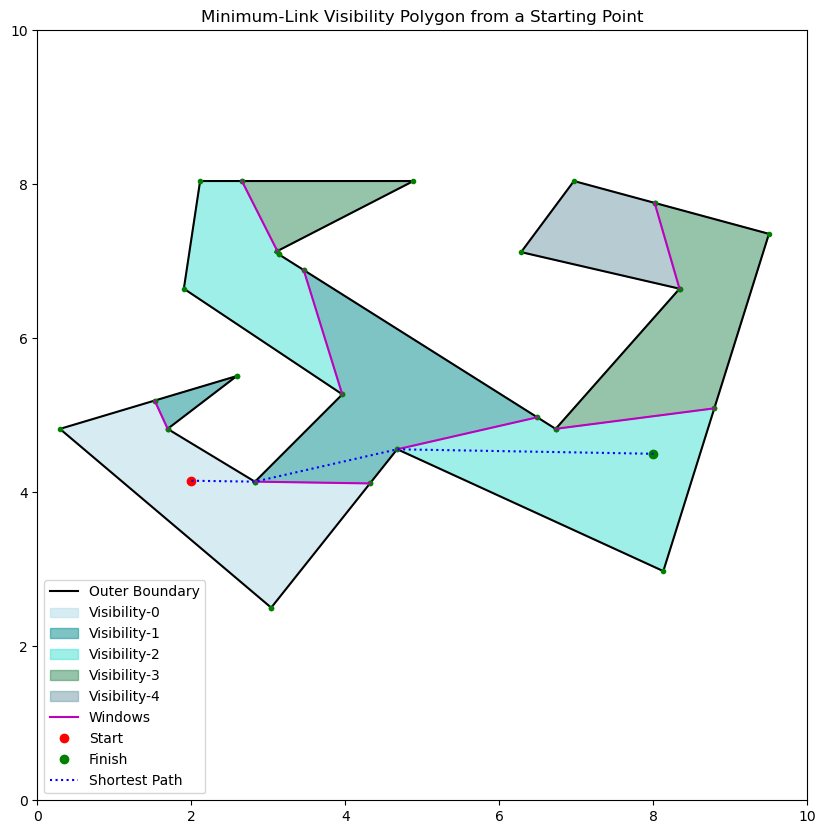

In [49]:
colors = ['#AEDAE7', '#008A8A', '#3FE0D0', '#2D8B57', '#6E9AA7']

fig, ax = plt.subplots(figsize=(10, 10))
ox, oy = zip(*polygon.exterior.coords)
ax.plot(ox, oy, 'k-', label='Outer Boundary')

# Draw and label the original boundary
for interior in polygon.interiors:
    hx, hy = zip(*interior.coords)
    ax.plot(hx, hy, 'k-', label='Hole')
    ax.plot(hx, hy, 'b.', label='Vertices')    
   
# Draw the segmented interior of the polygon
for step, regions in all_regions.items():
    for i, region in enumerate(regions):
        vx, vy = zip(*region.exterior.coords)
        ax.plot(vx,vy, 'g.')
        if i == 0:
            ax.fill(vx, vy, color=colors[step%len(colors)], alpha=0.5, label='Visibility-' + str(step))
        else:
            ax.fill(vx, vy, color=colors[step%len(colors)], alpha=0.5)           

# Draw all the windows
for i,item in enumerate(all_windows):
    px,py = zip(*item)
    if i == 0:
        ax.plot(px, py, "m-", label='Windows')
    else:
        ax.plot(px, py, "m-")

# Draw the starting point
ax.plot(*viewpoint, 'ro', label='Start')

# Show the index numbers of the vertices
#for i, (wx, wy) in enumerate(vert_set):
#    ax.text(wx, wy, str(i), ha='center', va='center', fontsize=10, color='darkred', zorder=4)

ax.plot(destination[0], destination[1], 'go', label='Finish')

rx,ry = zip(*final_path)
ax.plot(rx, ry, "b:", label='Shortest Path')

ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.set_aspect('equal')
plt.title("Minimum-Link Visibility Polygon from a Starting Point")
plt.legend()
plt.show()

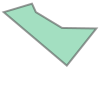

In [50]:
poly_set[0]

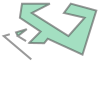

In [51]:
polygon - poly_set[0]
